In [18]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder_path = '/afs/inf.ed.ac.uk/user/s21/s2103701/Desktop/nls-catalogue-published-material_dc'

file_prefix = 'BIBLIOGRAPHIC_11573881650004341_'

file_end = '.xml'

data = pd.DataFrame()

for i in range(1,52):
    curr_file = file_prefix + str(i) + file_end
    file_path = os.path.join(folder_path, curr_file)

    df = pd.read_xml(file_path)

    data = pd.concat([data, df], ignore_index = True)

data
    


,title,creator,type,publisher,date,language,subject,description,coverage,relation,rights,identifier,format
0,Travel /,"Leeson, Edward,1947-2011.",text,London J. Murray,1980,eng,"Short stories, English.",None,None,None,None,None,None
1,Resource book of test items in chemistry,"Jenkins, E. W.(Edgar William)",text,London Murray,1981,eng,Chemistry,Bibliography: p15,None,None,None,None,None
2,Arbitration for contractors,"Stephenson, Douglas A.",text,Northwood Books,1982,NaN,None,None,None,None,None,None,None
3,Armorial bearings of the sovereigns of England...,Standing Conference for Local History.,text,London Bedford Square Press [for the] Standing...,1977,eng,Heraldry,Bibliography: p.29-31,None,None,None,None,None
4,"Sharing caring : caring, equal opportunities a...","Thompson, Catherine.",text,Community Care Project,[1985],NaN,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5091422,"Symfoni Nr. 5, Opus 50 = Symphony no. 5, opus ...","Fjeldsøe, Michael.edt",notated music,"Copenhagen : Edition Wilhelm Hansen,",1998.,zxx,Symphonies,"""Critical commentary,"" ""Filiation and evaluati...",None,None,None,None,None
5091423,Music for violin : from 'El Amor brujo' = Musi...,"Falla, Manuel de,1876-1946.Amor brujo.Danza ri...",notated music,"London : Chester Music,",c1996.,zxx,Ballets,Dance of terror (Danza del terror) -- Pantomim...,None,None,None,None,None
5091424,Fox trot ; and Celebration rag : for SATB reco...,"Hilling, Lyndon.",notated music,"London : Theo Wyatt,",c1984.,eng,None,Publ.no.,None,None,None,None,None
5091425,Fieber : Tondichtung : für Tenor und Orcheste...,"Lehár, Franz1870-1948.",notated music,London Glocken Verlag,[1995],ger,None,2827,None,None,None,None,None


In [10]:
import numpy as np

def extract_year(s):
    if not isinstance(s, str) or not s:
        return 0

    # Extract all numbers in the string
    numbers = re.findall(r'\d+', s)

    # If there's only one number in the string
    if len(numbers) == 1:
        num = numbers[0]
        
        
        # If it's more than 4 digits long
        if len(num) > 4:
            
            # If it's exactly 8 digits long
            if len(num) == 8:
                first_4_digits = int(num[:4])
                
                # If the first 4 digits are less than or equal to 2023
                if first_4_digits <= 2023:
                    return first_4_digits

            return 0

    # 1. Direct match for a 4-digit year no more than 2023.
    match_4_digits = re.search(r'^(\d{4})$', s)
    if match_4_digits:
        year = int(match_4_digits.group(1))
        
        if year < 1000:
            return 0
        
        if year <= 2023:
            return year

    # 3. Match a longer number followed by a 4-digit year.
    match_long_then_4_digits = re.search(r'\d{5,}.*?(\d{4})', s)
    if match_long_then_4_digits:
        year = int(match_long_then_4_digits.group(1))
        if year <= 2023:
            return year

    # 4 & 5. Handle two 4-digit numbers.
    match_two_4_digits = re.search(r'(\d{4}).*?(\d{4})', s)
    if match_two_4_digits:
        first_year = int(match_two_4_digits.group(1))
        second_year = int(match_two_4_digits.group(2))
        if first_year > 2023 and second_year <= 2023:
            return second_year
        if first_year <= 2023 and second_year <= 2023:
            return second_year

    # 6. Match 4-digit years with "c", ".", or within "[]".
    match_special = re.search(r'(\d{4}[c\.]?|\[\d{4}\])', s)
    if match_special:
        year = int(match_special.group(1).rstrip("c.").strip("[]"))
        if year <= 2023:
            return year
    
    # 7 & 8. Handle year ranges.
    year_ranges = re.findall(r'(\d{4})-(\d{4})', s)
    if year_ranges:
        if len(year_ranges) == 1:
            start_year, end_year = map(int, year_ranges[0])
            # If end year is more than 2023, return the start year
            if end_year > 2023:
                return start_year
            # Return the average of the start and end year
            if start_year <= 2023 and end_year <= 2023:
                return (start_year + end_year) // 2
            
        # If there are two ranges found
        elif len(year_ranges) == 2:
            first_start, first_end = map(int, year_ranges[0])
            second_start, second_end = map(int, year_ranges[1])
            # If both start and end of the first range are greater than 2023
            if first_start > 2023 and first_end > 2023:
                return (second_start + second_end) // 2

    return 0

data['year'] = data['date'].apply(extract_year)


In [15]:
year_defined = data[(data.year.isna()) == False]
year_defined = year_defined[['title','creator','type','publisher', 
                             'date', 'language', 'subject','description','year']]

year_defined

,title,creator,type,publisher,date,language,subject,description,year
0,Travel /,"Leeson, Edward,1947-2011.",text,London J. Murray,1980,eng,"Short stories, English.",None,1980
1,Resource book of test items in chemistry,"Jenkins, E. W.(Edgar William)",text,London Murray,1981,eng,Chemistry,Bibliography: p15,1981
2,Arbitration for contractors,"Stephenson, Douglas A.",text,Northwood Books,1982,NaN,None,None,1982
3,Armorial bearings of the sovereigns of England...,Standing Conference for Local History.,text,London Bedford Square Press [for the] Standing...,1977,eng,Heraldry,Bibliography: p.29-31,1977
4,"Sharing caring : caring, equal opportunities a...","Thompson, Catherine.",text,Community Care Project,[1985],NaN,None,None,1985
...,...,...,...,...,...,...,...,...,...
5091422,"Symfoni Nr. 5, Opus 50 = Symphony no. 5, opus ...","Fjeldsøe, Michael.edt",notated music,"Copenhagen : Edition Wilhelm Hansen,",1998.,zxx,Symphonies,"""Critical commentary,"" ""Filiation and evaluati...",1998
5091423,Music for violin : from 'El Amor brujo' = Musi...,"Falla, Manuel de,1876-1946.Amor brujo.Danza ri...",notated music,"London : Chester Music,",c1996.,zxx,Ballets,Dance of terror (Danza del terror) -- Pantomim...,1996
5091424,Fox trot ; and Celebration rag : for SATB reco...,"Hilling, Lyndon.",notated music,"London : Theo Wyatt,",c1984.,eng,None,Publ.no.,1984
5091425,Fieber : Tondichtung : für Tenor und Orcheste...,"Lehár, Franz1870-1948.",notated music,London Glocken Verlag,[1995],ger,None,2827,1995


In [17]:
year_language_defined = year_defined[(year_defined.language != 'und')&(year_defined.language != 'zxx')&(year_defined.language != 'd')&(year_defined.language != '- N') & (year_defined.language.isna() == False)]

year_language_defined

,title,creator,type,publisher,date,language,subject,description,year
0,Travel /,"Leeson, Edward,1947-2011.",text,London J. Murray,1980,eng,"Short stories, English.",None,1980
1,Resource book of test items in chemistry,"Jenkins, E. W.(Edgar William)",text,London Murray,1981,eng,Chemistry,Bibliography: p15,1981
3,Armorial bearings of the sovereigns of England...,Standing Conference for Local History.,text,London Bedford Square Press [for the] Standing...,1977,eng,Heraldry,Bibliography: p.29-31,1977
5,Environmental impact assessment a bibliography...,"Wathern, Peter.",text,London Mansell Information Publishing [etc.],1980,eng,Environmental impact analysis,Includes index,1980
6,Activities in the park /,"Gains, Pat.",text,[Welwyn Garden City] Nisbet,1985,eng,Amusements.,Cover title,1985
...,...,...,...,...,...,...,...,...,...
5091415,"Stabat Mater : ritibus, turi et campanis ante ...","Giles, Peter.",notated music,London Oecumuse,c1986,lat,None,p870331,1986
5091418,Walter & the pigeons : a musical in two acts /,"Archer, Malcolm.",notated music,"London : J. Weinberger,",c1996.,eng,Musicals,Production level cataloging.,1996
5091419,Mass in the Dorian mode,"Russill, Patrick1953-",notated music,Croydon Royal School of Church Music,c1990,lat,None,SP06,1990
5091424,Fox trot ; and Celebration rag : for SATB reco...,"Hilling, Lyndon.",notated music,"London : Theo Wyatt,",c1984.,eng,None,Publ.no.,1984


In [ ]:
pd.unique(data['date'])

212(no actual year), 976 --> 1976, 1000 --> 1776, 1004

/tmp/ipykernel_57249/699976432.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


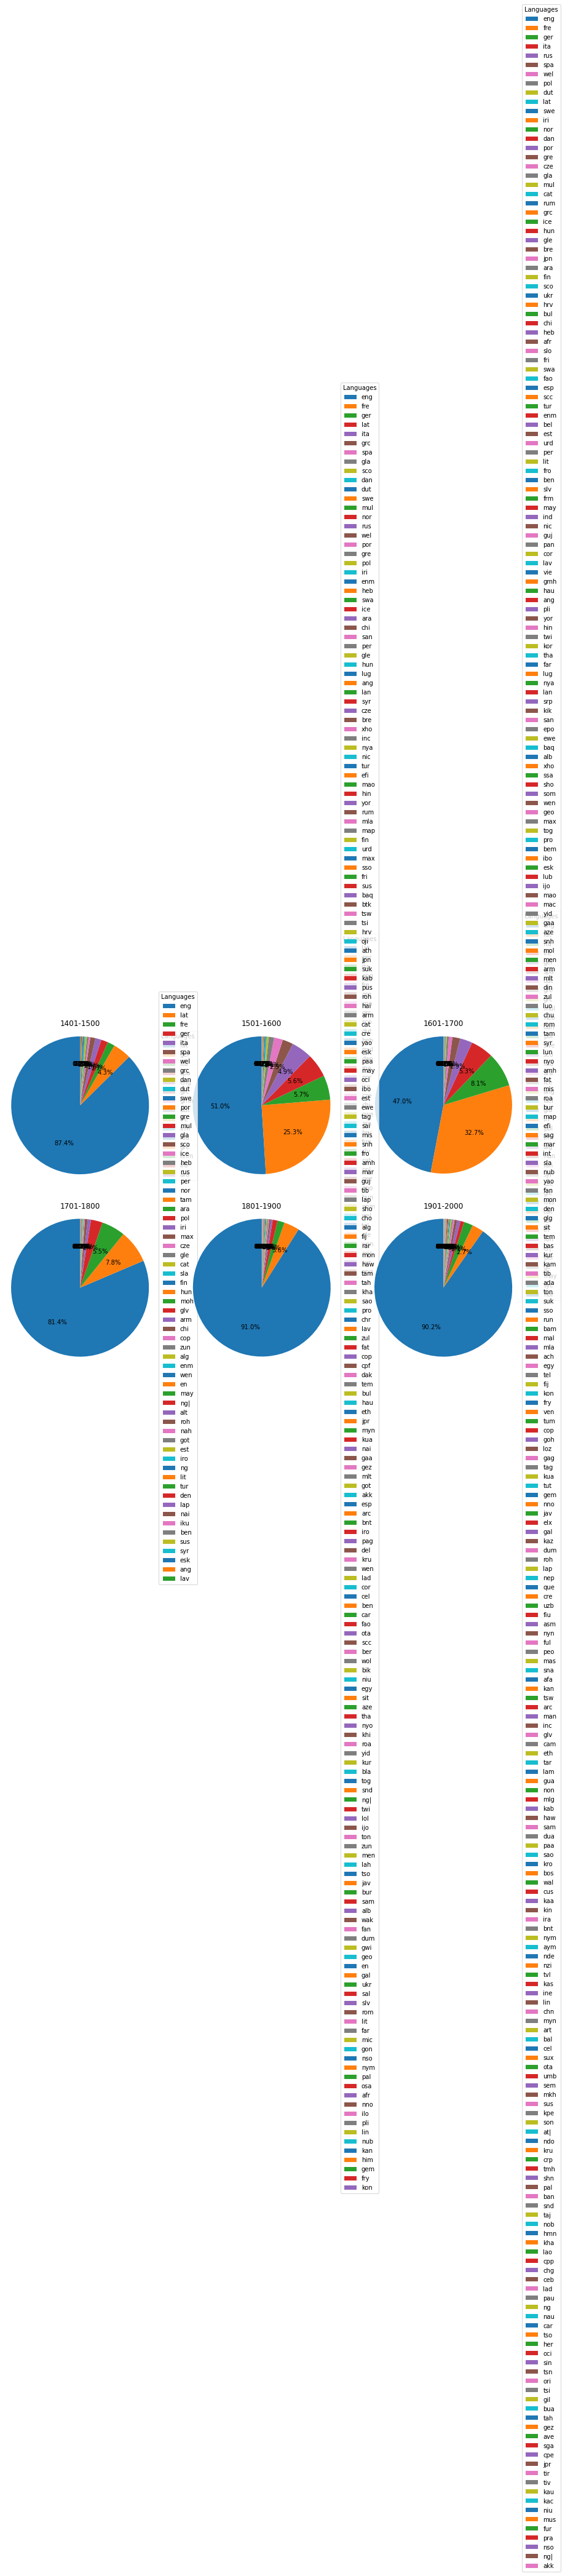

In [27]:
centuries = [(1401, 1500), (1501, 1600), (1601, 1700), (1701, 1800), (1801, 1900), (1901, 2000)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, (start, end) in zip(axes.ravel(), centuries):
    subset = year_language_defined[(year_language_defined['year'] >= start) & (year_language_defined['year'] <= end)]
    language_counts = subset['language'].value_counts()
    wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
    
    # Adding legend
    ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax.set_title(f"{start}-{end}")
    ax.axis('equal')

plt.tight_layout()
plt.show()


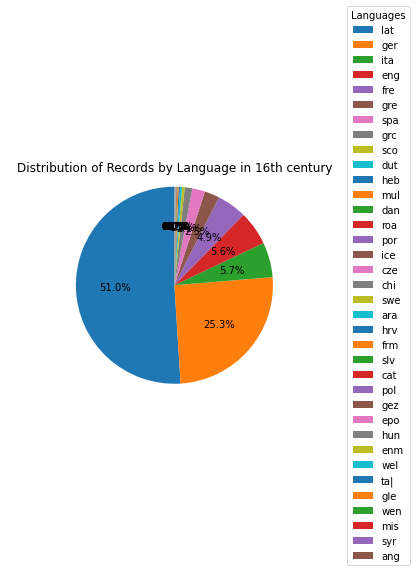

In [35]:
sixteenth_century = year_language_defined[(year_language_defined.year > 1500) & (year_language_defined. year <= 1600)]

# Count the records by language
language_counts = sixteenth_century['language'].value_counts()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Records by Language in 16th century')
plt.show()

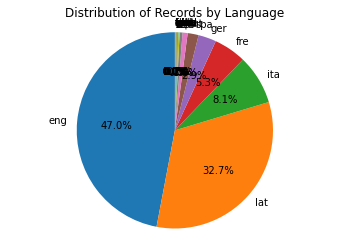

In [31]:
seventeenth_century = year_language_defined[(year_language_defined.year > 1600) & (year_language_defined. year <= 1700)]

# Count the records by language
language_counts = seventeenth_century['language'].value_counts()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Records by Language in 17th century')
plt.show()

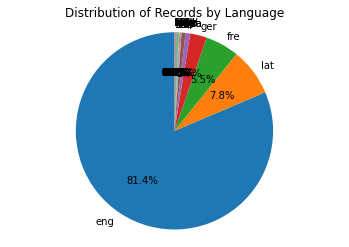

In [23]:
eighteenth_century = year_language_defined[(year_language_defined.year > 1700) & (year_language_defined. year <= 1800)]

# Count the records by language
language_counts = eighteenth_century['language'].value_counts()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Records by Language 18th century')
plt.show()

In [ ]:
nineteenth_century = year_language_defined[(year_language_defined.year > 1800) & (year_language_defined. year <= 1900)]

# Count the records by language
language_counts = nineteenth_century['language'].value_counts()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Records by Language in 19th century')
plt.show()

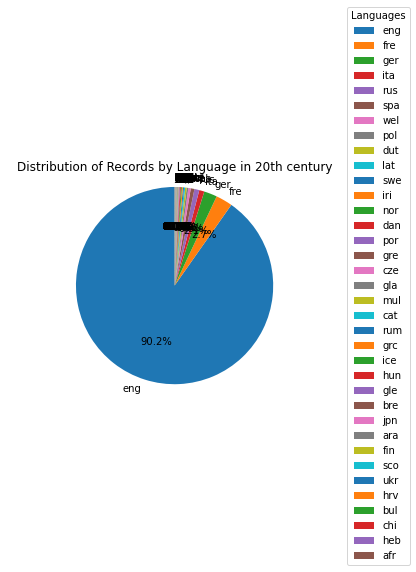

In [37]:
twentieth_century = year_language_defined[(year_language_defined.year > 1900) & (year_language_defined. year <= 2000)]

# Count the records by language
language_counts = twentieth_century['language'].value_counts()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(language_counts, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

ax.legend(wedges, language_counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Records by Language in 20th century')
plt.show()